# Assignment IV: Data Cleaning + EDA + Model

In this notebook I will:
1. Load the dataset
2. Clean and prepare the data
3. Do basic EDA (plots and observations)
4. Build a baseline ML model and an improved model
5. Evaluate results and discuss findings

In [62]:
import os, glob, csv , re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    mean_absolute_error, mean_squared_error, r2_score
)

from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

sns.set(style="whitegrid")
np.random.seed(42)

## 1) Load the dataset
We first load the dataset into a Pandas DataFrame.  
This allows us to inspect columns, missing values, and data types before modeling.

In [65]:

DATA_PATH = "/content/combined_data_environment.csv"

df = pd.read_csv(
    DATA_PATH,
    sep=";",
    encoding="latin1",
    engine="python",
    quoting=csv.QUOTE_NONE,
    on_bad_lines="skip"
)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()

Shape: (2862, 15)
Columns: ['title', 'publication_date', 'byline', 'content', 'subject', 'country', 'city', 'person', 'industry', 'company', 'word_count', 'publication_date_text', 'publication', 'author', 'copyright']


title  \
Egypt at the forefront of developing green and ... 01.01.22 NaN             "Egypt at the forefront of developing green and...  clean water and sanitation, SDG 7                  affordable and clean energy, SDG 9                 industry, innovation, and infrastructure           SDG 11  sustainable cities and communities and SDG 13      climate action. This determination comes in li...  reducing absolute energy consumption by 15%, r...  solar, wind, geothermal, biomass, biogas, and ...  åÊvehicles, clean transportation, appliances a...   
Inequality, climate change and economic recover... 29.11.21 FinTech Futures Inequality, climate change and economic recover... ['CLIMATE CHANGE', 'GREEN FINANCE', 'ECONOMIC R... ['AFRICA', 'SOUTH AFRICA', 'EASTERN AFRICA', 'M... []                                                 []      ['SIC6021 NATIONAL COMMERCIAL BANKS', 'GREEN FI... ['AFRICAN DEVELOPMENT BANK GROUP']                 699                                                November 29, 2021 Monday                                                       ['Fintechfutures.com']   
11th UK-India Economic and Financial Dialogue J... 02.09.21 NaN             11th UK-India Economic and Financial Dialogue J... ['PUBLIC FINANCE', 'COVID CORONAVIRUS', 'COVID-... ['UNITED KINGDOM', 'INDIA', 'BRICS MEMBER STATES'] ['LONDON, ENGLAND']                                []      ['PUBLIC FINANCE AGENCIES & TREASURIES', 'TREAS... []                                                 3560                                               September 2, 2021 Thursday                                                    ['Impact News Service']   
Together we can mobilise capital and achieve ne... 11.01.22 AXEL A. WEBER   Together we can mobilise capital and achieve ne... ['SUSTAINABLE DEVELOPMENT', 'AGREEMENTS', 'CLIM... ['CHINA', 'UNITED STATES', 'ASIA', 'EUROPE']       []                                                 []      ['SUSTAINABLE DEVELOPMENT', 'BANKING & FINANCE'... []                                                 1004                                               January 11, 2022 Tuesday                                                           ['The Australian']   
Silicon Valley Bank Commits to $5 Billion in Su... 10.01.22 NaN             "Silicon Valley Bank Commits to $5 Billion in S... ['PRESS RELEASES', 'SUSTAINABLE DEVELOPMENT', '... []                                                 ['SAN FRANCISCO BAY AREA, CA, USA', 'SILICON VA... []      ['NAICS325412 PHARMACEUTICAL PREPARATION MANUFA... ['GEOPHARMA INC', 'SILICON VALLEY BANK']           719                                                January 10, 2022 Monday                                                               ['PR Newswire']   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              publication_date  \
Egypt at the forefront of developing green and ... 01.01.22 NaN             "Egypt at the forefront of developing green and...  clean water and sanitation, SDG 7                  affordable and clean energy, SDG 9                 industry, innovation, and infrastructure           SDG 11  sustainable cities and communities and SDG 13      climate action. This determination comes in li...  reducing absolute energy consumption by 15%, r...  solar, wind, geothermal, biomass, biogas, and ...   buildings that comply with green buildings st...   
Inequality, climate change and economic recover... 29.11.21 FinTech Futures Inequality, climate change and economic recover... ['CLIMATE CHANGE', 'GREEN FINANCE', 'ECON

In [66]:
# Fix index issues (some rows may have been read as a MultiIndex)
print("Index type BEFORE:", type(df.index))

df = df.reset_index(drop=True)

print("Index type AFTER:", type(df.index))
print("Shape (still):", df.shape)
df.head()

Index type BEFORE: <class 'pandas.core.indexes.multi.MultiIndex'>
Index type AFTER: <class 'pandas.core.indexes.range.RangeIndex'>
Shape (still): (2862, 15)


,title,publication_date,byline,content,subject,country,city,person,industry,company,word_count,publication_date_text,publication,author,copyright
0,"åÊvehicles, clean transportation, appliances a...",buildings that comply with green buildings st...,decrease in water utilisation from baseline b...,compliance with ISO 50001 or equivalent certi...,"['GREEN FINANCE', 'BOND MARKETS', 'SUSTAINABLE...","['EGYPT', 'AFRICA', 'MIDDLE EAST', 'NORTHERN A...","['GLASGOW, SCOTLAND']",[],"['GREEN FINANCE', 'BOND MARKETS', 'SUSTAINABLE...",[],1827,Jan 22,['Euromoney'],NaN,Copyright 2022 Euromoney Institutional Investo...
1,['Fintechfutures.com'],FinTech Futures,Copyright 2021 Informal PLC All Rights Reserved,None,None,None,None,None,None,None,None,None,None,None,None
2,['Impact News Service'],NaN,Copyright 2021 Impact Media Limited All Rights...,None,None,None,None,None,None,None,None,None,None,None,None
3,['The Australian'],AXEL A. WEBER,Copyright 2022 Nationwide News Pty Limited All...,None,None,None,None,None,None,None,None,None,None,None,None
4,['PR Newswire'],NaN,Copyright 2022 PR Newswire Association LLC All...,None,None,None,None,None,None,None,None,None,None,None,None


## 2) Data Cleaning + Preparation

In this step I will:
- Clean missing values and list-like text fields.
- Create a target column `country_clean` by extracting the first country from the `country` field (which is stored as a list-like string).
- Create a single text feature by combining `title` and `content`.

This prepared dataset will be used in Task 3 (EDA) and Task 4 (modeling).

In [67]:
# Replace some common "empty" patterns with NaN (more consistent missing values)
df = df.replace(["None", "none", "[]", ""], np.nan)

# Make sure text columns are strings (avoid errors later)
for col in ["title", "content", "country"]:
    if col in df.columns:
        df[col] = df[col].astype("string")

# Extract first country from list-like string in `country`
def first_country(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    # Example: "['EGYPT', 'AFRICA', ...]" -> "EGYPT"
    m = re.search(r"\['([^']+)'", s)
    if m:
        return m.group(1).strip()
    return np.nan

df["country_clean"] = df["country"].apply(first_country)

# Create text feature for ML
df["text"] = df["title"].fillna("") + " " + df["content"].fillna("")

# Build modeling dataset: need target + some text
df_model = df.dropna(subset=["country_clean"]).copy()

print("Rows in df_model:", len(df_model))
print("Top 10 target classes:\n", df_model["country_clean"].value_counts().head(10))
df_model[["country_clean", "title", "content"]].head()

Rows in df_model: 146
Top 10 target classes:
 country_clean
Newstex Blogs                        14
ENP Newswire                          6
MENAFN - Press Releases (English)     5
Global Capital Euroweek               5
NAICS522110 COMMERCIAL BANKING        5
Targeted News Service                 5
GREEN FINANCE                         5
Indian Government News                5
HONG KONG                             4
Thai News Service                     4
Name: count, dtype: int64


,country_clean,title,content
0,EGYPT,"åÊvehicles, clean transportation, appliances a...",compliance with ISO 50001 or equivalent certi...
11,Global Capital Euroweek,<NA>,3541
39,Taiwan Business News,<NA>,2407
42,Global Capital Euroweek,<NA>,1608
92,LiveNews.co.nz,<NA>,3766


## 3) Exploratory Data Analysis (EDA)

In this section, I will:
- Look at the distribution of the target variable (`country_clean`)
- Look at missing values in key columns (`title`, `content`, `word_count`)
- Look at the text length distribution (how long articles are)

These checks help us understand class imbalance and data quality before modeling.

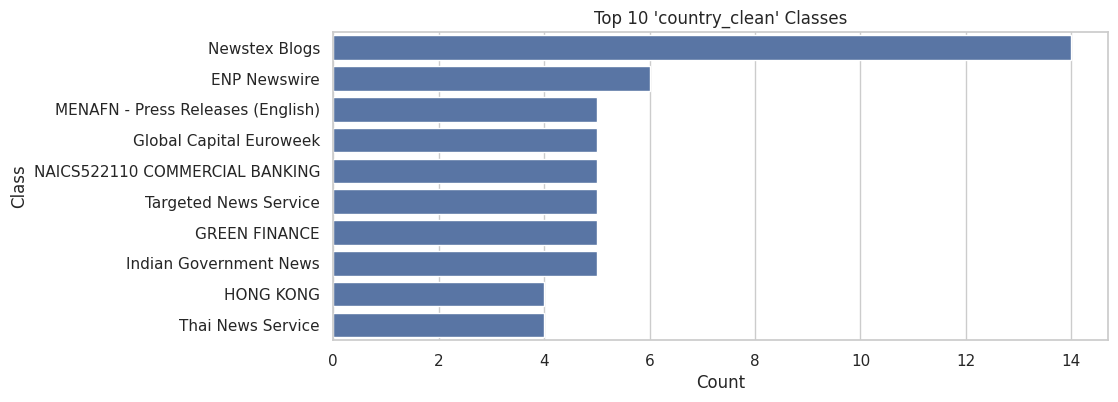

,count
country_clean,
Newstex Blogs,14
ENP Newswire,6
MENAFN - Press Releases (English),5
Global Capital Euroweek,5
NAICS522110 COMMERCIAL BANKING,5
Targeted News Service,5
GREEN FINANCE,5
Indian Government News,5
HONG KONG,4


In [68]:
# Distribution of target classes (top 10)
top = df_model["country_clean"].value_counts().head(10)

plt.figure(figsize=(10,4))
sns.barplot(x=top.values, y=top.index)
plt.title("Top 10 'country_clean' Classes")
plt.xlabel("Count")
plt.ylabel("Class")
plt.show()

top

In [69]:
# Missing values in key columns
missing_check = df[["title", "content", "country", "word_count"]].isna().mean().sort_values(ascending=False) * 100
missing_check

,0
word_count,97.204752
country,84.032145
content,66.736548
title,7.686932


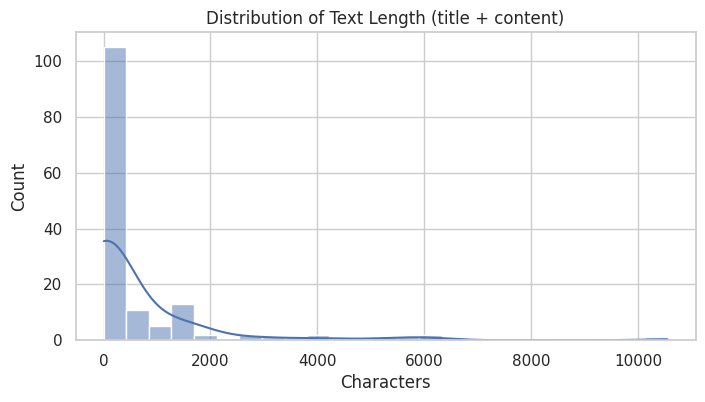

,text_len
count,146.0
mean,598.924658
std,1429.893852
min,4.0
25%,4.0
50%,5.0
75%,596.25
max,10549.0


In [70]:
df_model["text_len"] = df_model["text"].str.len()

plt.figure(figsize=(8,4))
sns.histplot(df_model["text_len"], bins=25, kde=True)
plt.title("Distribution of Text Length (title + content)")
plt.xlabel("Characters")
plt.show()

df_model["text_len"].describe()

## 4) Modeling (Baseline + Improved)

For modeling, I will use the combined text (`title + content`) as input features.

Because the dataset is imbalanced and some classes have very few examples, I will keep only the **top N most frequent classes**.
This makes train/test splitting more stable and makes evaluation more meaningful.

Models:
1. Baseline: TF-IDF + Logistic Regression
2. Improved: TF-IDF + Logistic Regression with hyperparameter tuning (GridSearchCV)

In [72]:

# Keep only the top N classes to reduce noise and make the split stable
N_CLASSES = 8
top_classes = df_model["country_clean"].value_counts().head(N_CLASSES).index

df_top = df_model[df_model["country_clean"].isin(top_classes)].copy()

X = df_top["text"]
y = df_top["country_clean"]

print("Rows after keeping top classes:", len(df_top))
print("Class distribution:\n", y.value_counts())

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", len(X_train), "Test size:", len(X_test))

Rows after keeping top classes: 50
Class distribution:
 country_clean
Newstex Blogs                        14
ENP Newswire                          6
MENAFN - Press Releases (English)     5
Global Capital Euroweek               5
GREEN FINANCE                         5
Targeted News Service                 5
NAICS522110 COMMERCIAL BANKING        5
Indian Government News                5
Name: count, dtype: int64
Train size: 40 Test size: 10


In [73]:
baseline = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english", max_features=10000)),
    ("clf", LogisticRegression(max_iter=1000))
])

baseline.fit(X_train, y_train)
pred_base = baseline.predict(X_test)

print("Baseline Accuracy:", accuracy_score(y_test, pred_base))
print("\nClassification Report (Baseline):\n")
print(classification_report(y_test, pred_base))

Baseline Accuracy: 0.5

Classification Report (Baseline):

                                   precision    recall  f1-score   support

                     ENP Newswire       0.00      0.00      0.00         1
                    GREEN FINANCE       0.00      0.00      0.00         1
          Global Capital Euroweek       0.00      0.00      0.00         1
           Indian Government News       1.00      1.00      1.00         1
MENAFN - Press Releases (English)       0.00      0.00      0.00         1
   NAICS522110 COMMERCIAL BANKING       1.00      1.00      1.00         1
                    Newstex Blogs       0.38      1.00      0.55         3
            Targeted News Service       0.00      0.00      0.00         1

                         accuracy                           0.50        10
                        macro avg       0.30      0.38      0.32        10
                     weighted avg       0.31      0.50      0.36        10



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [74]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__min_df": [1, 2],
    "clf__C": [0.5, 1, 2, 5]
}

grid = GridSearchCV(
    baseline,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=3,
    n_jobs=-1
)

grid.fit(X_train, y_train)

best_model = grid.best_estimator_
pred_best = best_model.predict(X_test)

print("Best Params:", grid.best_params_)
print("Improved Accuracy:", accuracy_score(y_test, pred_best))
print("\nClassification Report (Improved):\n")
print(classification_report(y_test, pred_best))

Best Params: {'clf__C': 2, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1)}
Improved Accuracy: 0.5

Classification Report (Improved):

                                   precision    recall  f1-score   support

                     ENP Newswire       0.00      0.00      0.00         1
                    GREEN FINANCE       0.00      0.00      0.00         1
          Global Capital Euroweek       0.00      0.00      0.00         1
           Indian Government News       1.00      1.00      1.00         1
MENAFN - Press Releases (English)       0.00      0.00      0.00         1
   NAICS522110 COMMERCIAL BANKING       1.00      1.00      1.00         1
                    Newstex Blogs       0.38      1.00      0.55         3
            Targeted News Service       0.00      0.00      0.00         1

                         accuracy                           0.50        10
                        macro avg       0.30      0.38      0.32        10
                     weighted avg    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 5) Evaluation + Results Discussion

In this final section, I will:
- Visualize the confusion matrix for the baseline and improved models
- Summarize model performance using accuracy and F1-scores
- Discuss limitations (small dataset, class imbalance, missing text) and possible improvements

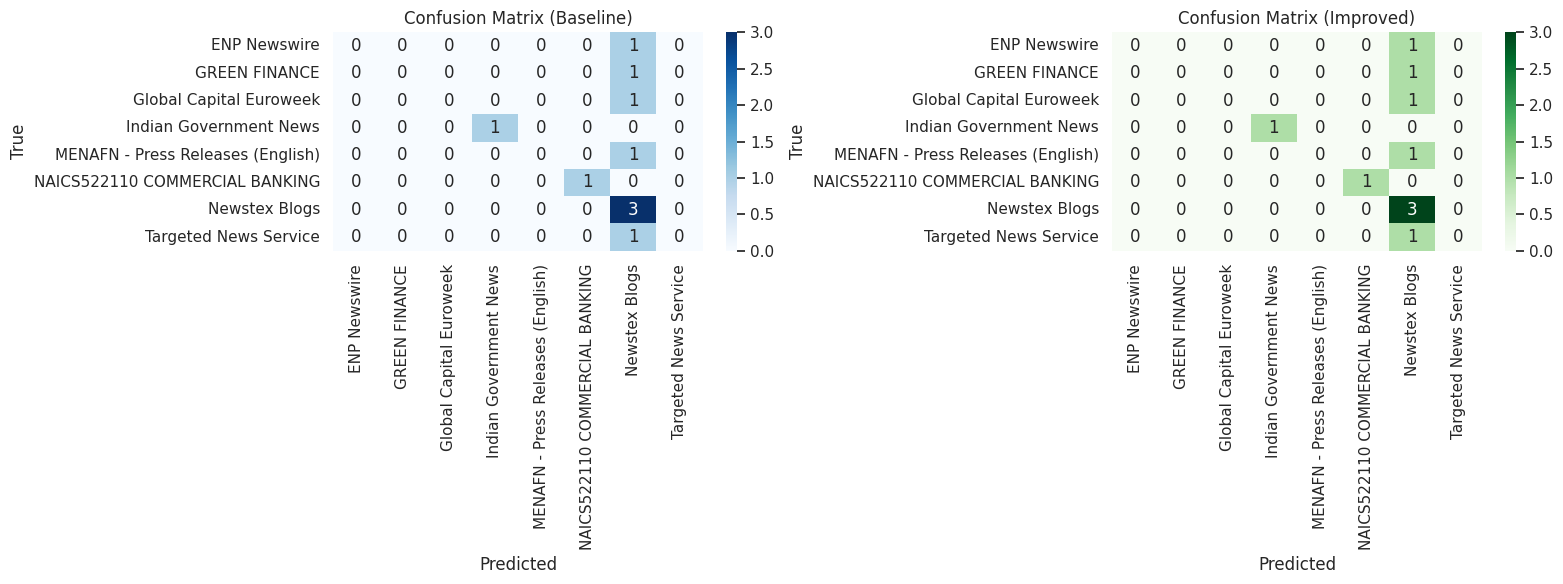

In [76]:

labels = sorted(y_test.unique())

cm_base = confusion_matrix(y_test, pred_base, labels=labels)
cm_best = confusion_matrix(y_test, pred_best, labels=labels)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(cm_base, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_title("Confusion Matrix (Baseline)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

sns.heatmap(cm_best, annot=True, fmt="d", cmap="Greens",
            xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_title("Confusion Matrix (Improved)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()

In [64]:
# Quick validation: check if columns look correct
print(df[["title", "publication_date", "country", "word_count"]].head(5))
df.info()

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         title  \
Egypt at the forefront of developing green and ... 01.01.22 NaN             "Egypt at the forefront of developing green and...  clean water and sanitation, SDG 7                  affordable and clean energy, SDG 9                 industry, innovation, and infrastructure           SDG 11  sustainable cities and communities and SDG 13      climate action. This determination comes in li...  reducing absolute energy consumption by 15%, r...  solar, wind,

In [ ]:
import re

# 1) Convert word_count to numeric; corrupted rows become NaN
df["word_count_num"] = pd.to_numeric(df["word_count"], errors="coerce")

# 2) Extract first country from list-like strings
def extract_first_country(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    # Example: "['AFRICA', 'SOUTH AFRICA']" -> AFRICA
    m = re.search(r"\['([^']+)'\]", s)
    if m:
        return m.group(1).strip()
    # If it's not list-like, keep as-is (still better than losing it)
    return s

df["country_clean"] = df["country"].apply(extract_first_country)

# 3) Filter to "good rows" for modeling:
# - word_count_num must exist (means row is not heavily corrupted)
# - title and content must exist
# - country_clean must exist
df_model = df.dropna(subset=["word_count_num", "title", "content", "country_clean"]).copy()

# Optional: remove very rare classes to make modeling easier
min_class_size = 10
class_counts = df_model["country_clean"].value_counts()
keep_classes = class_counts[class_counts >= min_class_size].index
df_model = df_model[df_model["country_clean"].isin(keep_classes)].copy()

print("Rows after cleaning:", df_model.shape[0])
print("Number of classes after filtering:", df_model["country_clean"].nunique())
print(df_model["country_clean"].value_counts().head(10))

In [59]:
if isinstance(df.index, pd.MultiIndex):
    df = df.reset_index()
    print("Reset MultiIndex -> normal index. New shape:", df.shape)

df.head()

,title,publication_date,byline,content,subject,country,city,person,industry,company,word_count,publication_date_text,publication,author,copyright
0,Egypt at the forefront of developing green and...,01.01.22,NaN,"""Egypt at the forefront of developing green an...","clean water and sanitation, SDG 7","affordable and clean energy, SDG 9","industry, innovation, and infrastructure",SDG 11,sustainable cities and communities and SDG 13,climate action. This determination comes in l...,"reducing absolute energy consumption by 15%, ...","solar, wind, geothermal, biomass, biogas, and...","åÊvehicles, clean transportation, appliances a...",buildings that comply with green buildings st...,decrease in water utilisation from baseline b...
1,"Inequality, climate change and economic recove...",29.11.21,FinTech Futures,"Inequality, climate change and economic recove...","['CLIMATE CHANGE', 'GREEN FINANCE', 'ECONOMIC ...","['AFRICA', 'SOUTH AFRICA', 'EASTERN AFRICA', '...",[],[],"['SIC6021 NATIONAL COMMERCIAL BANKS', 'GREEN F...",['AFRICAN DEVELOPMENT BANK GROUP'],699,"November 29, 2021 Monday",['Fintechfutures.com'],FinTech Futures,Copyright 2021 Informal PLC All Rights Reserved
2,11th UK-India Economic and Financial Dialogue ...,02.09.21,NaN,11th UK-India Economic and Financial Dialogue ...,"['PUBLIC FINANCE', 'COVID CORONAVIRUS', 'COVID...","['UNITED KINGDOM', 'INDIA', 'BRICS MEMBER STAT...","['LONDON, ENGLAND']",[],"['PUBLIC FINANCE AGENCIES & TREASURIES', 'TREA...",[],3560,"September 2, 2021 Thursday",['Impact News Service'],NaN,Copyright 2021 Impact Media Limited All Rights...
3,"""""""Being the Change We Want to See: A Sustaina...",09.06.21,NaN,"""""""Being the Change We Want to See: A Sustaina...",and * promoting high-quality sustainability-r...,- more effective risk management and market d...,and - effective allocation of capital towards...,* promoting green finance solutions and markets,* harnessing technology to enable trusted sus...,and * building knowledge and capabilities in ...,* seize investment opportunities from the tra...,and * support the transition of portfolio com...,- attract sustainability-focused asset manage...,and - catalyse funding towards environmentall...,and * developing strategies to reduce our foo...
4,Together we can mobilise capital and achieve n...,11.01.22,AXEL A. WEBER,Together we can mobilise capital and achieve n...,"['SUSTAINABLE DEVELOPMENT', 'AGREEMENTS', 'CLI...","['CHINA', 'UNITED STATES', 'ASIA', 'EUROPE']",[],[],"['SUSTAINABLE DEVELOPMENT', 'BANKING & FINANCE...",[],1004,"January 11, 2022 Tuesday",['The Australian'],AXEL A. WEBER,Copyright 2022 Nationwide News Pty Limited All...


In [60]:
# Drop index-artifact columns created by resetting a MultiIndex
level_cols = [c for c in df.columns if str(c).startswith("level_")]
print("Dropping these index-artifact columns:", level_cols)

df = df.drop(columns=level_cols)

print("Shape after dropping level_* columns:", df.shape)
df.head()

Dropping these index-artifact columns: []
Shape after dropping level_* columns: (2969, 15)


,title,publication_date,byline,content,subject,country,city,person,industry,company,word_count,publication_date_text,publication,author,copyright
0,Egypt at the forefront of developing green and...,01.01.22,NaN,"""Egypt at the forefront of developing green an...","clean water and sanitation, SDG 7","affordable and clean energy, SDG 9","industry, innovation, and infrastructure",SDG 11,sustainable cities and communities and SDG 13,climate action. This determination comes in l...,"reducing absolute energy consumption by 15%, ...","solar, wind, geothermal, biomass, biogas, and...","åÊvehicles, clean transportation, appliances a...",buildings that comply with green buildings st...,decrease in water utilisation from baseline b...
1,"Inequality, climate change and economic recove...",29.11.21,FinTech Futures,"Inequality, climate change and economic recove...","['CLIMATE CHANGE', 'GREEN FINANCE', 'ECONOMIC ...","['AFRICA', 'SOUTH AFRICA', 'EASTERN AFRICA', '...",[],[],"['SIC6021 NATIONAL COMMERCIAL BANKS', 'GREEN F...",['AFRICAN DEVELOPMENT BANK GROUP'],699,"November 29, 2021 Monday",['Fintechfutures.com'],FinTech Futures,Copyright 2021 Informal PLC All Rights Reserved
2,11th UK-India Economic and Financial Dialogue ...,02.09.21,NaN,11th UK-India Economic and Financial Dialogue ...,"['PUBLIC FINANCE', 'COVID CORONAVIRUS', 'COVID...","['UNITED KINGDOM', 'INDIA', 'BRICS MEMBER STAT...","['LONDON, ENGLAND']",[],"['PUBLIC FINANCE AGENCIES & TREASURIES', 'TREA...",[],3560,"September 2, 2021 Thursday",['Impact News Service'],NaN,Copyright 2021 Impact Media Limited All Rights...
3,"""""""Being the Change We Want to See: A Sustaina...",09.06.21,NaN,"""""""Being the Change We Want to See: A Sustaina...",and * promoting high-quality sustainability-r...,- more effective risk management and market d...,and - effective allocation of capital towards...,* promoting green finance solutions and markets,* harnessing technology to enable trusted sus...,and * building knowledge and capabilities in ...,* seize investment opportunities from the tra...,and * support the transition of portfolio com...,- attract sustainability-focused asset manage...,and - catalyse funding towards environmentall...,and * developing strategies to reduce our foo...
4,Together we can mobilise capital and achieve n...,11.01.22,AXEL A. WEBER,Together we can mobilise capital and achieve n...,"['SUSTAINABLE DEVELOPMENT', 'AGREEMENTS', 'CLI...","['CHINA', 'UNITED STATES', 'ASIA', 'EUROPE']",[],[],"['SUSTAINABLE DEVELOPMENT', 'BANKING & FINANCE...",[],1004,"January 11, 2022 Tuesday",['The Australian'],AXEL A. WEBER,Copyright 2022 Nationwide News Pty Limited All...


In [61]:

df.info()

df.isna().sum().sort_values(ascending=False).head(15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2969 entries, 0 to 2968
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   title                  2965 non-null   object
 1   publication_date       2969 non-null   object
 2   byline                 1001 non-null   object
 3   content                2922 non-null   object
 4   subject                2959 non-null   object
 5   country                2967 non-null   object
 6   city                   2969 non-null   object
 7   person                 2969 non-null   object
 8   industry               2968 non-null   object
 9   company                2968 non-null   object
 10  word_count             2969 non-null   object
 11  publication_date_text  2969 non-null   object
 12  publication            2969 non-null   object
 13  author                 1770 non-null   object
 14  copyright              2770 non-null   object
dtypes: object(15)
memory 

,0
byline,1968
author,1199
copyright,199
content,47
subject,10
title,4
country,2
industry,1
company,1
city,0


In [48]:
# The "level_*" columns are artifacts from a MultiIndex created during a bad CSV read.
# They are not real features we want for analysis/modeling.

level_cols = [c for c in df.columns if str(c).startswith("level_")]
print("Dropping these index-artifact columns:", level_cols)

df = df.drop(columns=level_cols)

print("Shape after dropping level_* columns:", df.shape)
print("Columns now:", df.columns.tolist())

df.head()

Dropping these index-artifact columns: ['level_0', 'level_1', 'level_2', 'level_3', 'level_4', 'level_5', 'level_6', 'level_7', 'level_8', 'level_9', 'level_10', 'level_11']
Shape after dropping level_* columns: (2862, 15)
Columns now: ['title', 'publication_date', 'byline', 'content', 'subject', 'country', 'city', 'person', 'industry', 'company', 'word_count', 'publication_date_text', 'publication', 'author', 'copyright']


,title,publication_date,byline,content,subject,country,city,person,industry,company,word_count,publication_date_text,publication,author,copyright
0,"åÊvehicles, clean transportation, appliances a...",buildings that comply with green buildings st...,decrease in water utilisation from baseline b...,compliance with ISO 50001 or equivalent certi...,"['GREEN FINANCE', 'BOND MARKETS', 'SUSTAINABLE...","['EGYPT', 'AFRICA', 'MIDDLE EAST', 'NORTHERN A...","['GLASGOW, SCOTLAND']",[],"['GREEN FINANCE', 'BOND MARKETS', 'SUSTAINABLE...",[],1827,Jan 22,['Euromoney'],NaN,Copyright 2022 Euromoney Institutional Investo...
1,['Fintechfutures.com'],FinTech Futures,Copyright 2021 Informal PLC All Rights Reserved,None,None,None,None,None,None,None,None,None,None,None,None
2,['Impact News Service'],NaN,Copyright 2021 Impact Media Limited All Rights...,None,None,None,None,None,None,None,None,None,None,None,None
3,['The Australian'],AXEL A. WEBER,Copyright 2022 Nationwide News Pty Limited All...,None,None,None,None,None,None,None,None,None,None,None,None
4,['PR Newswire'],NaN,Copyright 2022 PR Newswire Association LLC All...,None,None,None,None,None,None,None,None,None,None,None,None


## 2) Quick inspection

I check column names, data types, and missing values so I know what cleaning is needed.

In [49]:
print("Columns:", df.columns.tolist())
df.info()

missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing / len(df) * 100).round(2)
display(pd.DataFrame({"missing_count": missing, "missing_pct": missing_pct}))

Columns: ['title', 'publication_date', 'byline', 'content', 'subject', 'country', 'city', 'person', 'industry', 'company', 'word_count', 'publication_date_text', 'publication', 'author', 'copyright']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2862 entries, 0 to 2861
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   title                  2862 non-null   object
 1   publication_date       1663 non-null   object
 2   byline                 2663 non-null   object
 3   content                1010 non-null   object
 4   subject                744 non-null    object
 5   country                503 non-null    object
 6   city                   346 non-null    object
 7   person                 273 non-null    object
 8   industry               154 non-null    object
 9   company                145 non-null    object
 10  word_count             80 non-null     object
 11  publication_date_text  59

,missing_count,missing_pct
author,2850,99.58
copyright,2845,99.41
publication,2815,98.36
publication_date_text,2803,97.94
word_count,2782,97.20
company,2717,94.93
industry,2708,94.62
person,2589,90.46
city,2516,87.91
country,2359,82.42


In [50]:
# Convert word_count to numeric (invalid values become NaN)
df["word_count"] = pd.to_numeric(df["word_count"], errors="coerce")
print("word_count numeric. Missing after conversion:", df["word_count"].isna().sum())
df[["word_count"]].describe()

word_count numeric. Missing after conversion: 2845


,word_count
count,17.000000
mean,1546.764706
std,598.980230
min,592.000000
25%,1195.000000
50%,1613.000000
75%,1868.000000
max,2834.000000


## Target selection

Originally, I attempted to use `country` as the prediction target. However, after inspecting `country_clean` values, many labels are not actual countries (they include publisher names, copyright strings, and industry codes).  
To make the machine learning task meaningful, I will instead predict `publication`, which represents the source of the article and is more consistent for this dataset.

In [51]:
import re

def normalize_listish_text(x):
    """
    Many columns contain values like "['A', 'B']" stored as strings.
    This function converts them into a plain text string "A B".
    """
    if pd.isna(x):
        return ""
    s = str(x)
    # remove brackets and quotes
    s = re.sub(r"[\[\]'\"\,]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

# Choose a better target
TARGET = "publication_date"

df_model = df.copy()

# Clean target (publication is also sometimes list-like)
df_model[TARGET] = df_model[TARGET].apply(normalize_listish_text)
df_model[TARGET] = df_model[TARGET].str.strip()

# Drop missing/empty targets
df_model = df_model[df_model[TARGET].str.len() > 0].copy()

# Keep only values that look like dates (simple rule: must contain a year like 20xx)
df_model = df_model[df_model[TARGET].str.contains(r"20\d{2}", regex=True)].copy()

# Clean text columns we will use as features
text_cols = ["title", "byline", "content", "subject"]
for c in text_cols:
    df_model[c] = df_model[c].apply(normalize_listish_text)

# Convert word_count safely (optional numeric feature)
df_model["word_count_num"] = pd.to_numeric(df_model.get("word_count", np.nan), errors="coerce")
df_model["word_count_num"] = df_model["word_count_num"].fillna(df_model["word_count_num"].median())

print("Modeling rows/cols:", df_model.shape)
print("Top 10 target classes:")
display(df_model[TARGET].value_counts().head(10))

Modeling rows/cols: (297, 16)
Top 10 target classes:


,count
publication_date,
December 4 2023 Monday,21
November 17 2022 Thursday,6
December 5 2023 Tuesday,5
December 23 2016 Friday,4
March 22 2021 Monday,3
March 10 2021 Wednesday,3
October 7 2023 Saturday,3
August 18 2021 Wednesday,3
November 13 2023 Monday,3


## 4) EDA (Exploratory Data Analysis)

In this section I will:
1. Check how many examples per target class we have (class balance).
2. Visualize the most common classes.
3. Look at basic text length / word count distributions to understand the data.

Number of classes: 224
Total rows: 297


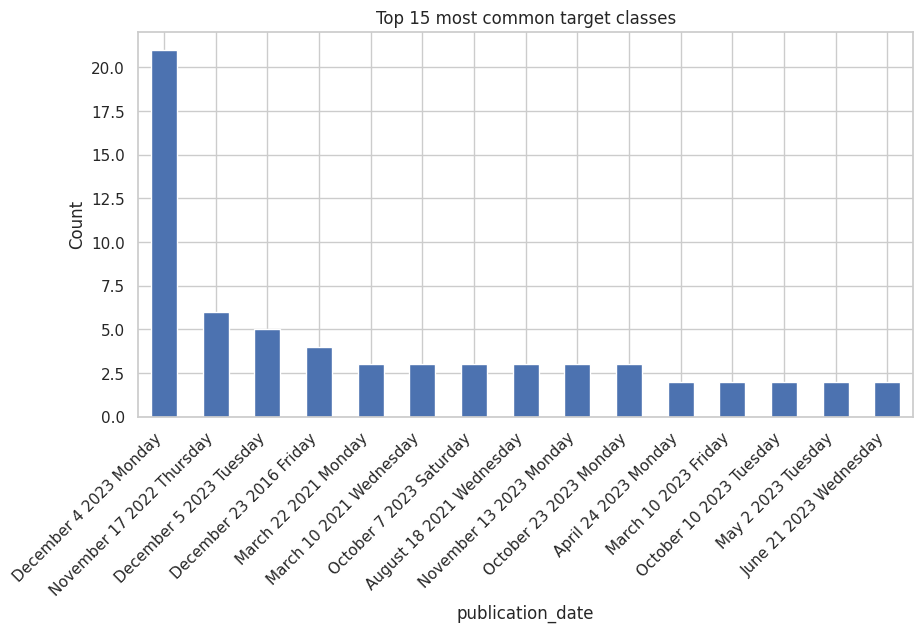

In [52]:
# Class balance
class_counts = df_model[TARGET].value_counts()
print("Number of classes:", class_counts.shape[0])
print("Total rows:", len(df_model))

plt.figure(figsize=(10,5))
class_counts.head(15).plot(kind="bar")
plt.title("Top 15 most common target classes")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.show()

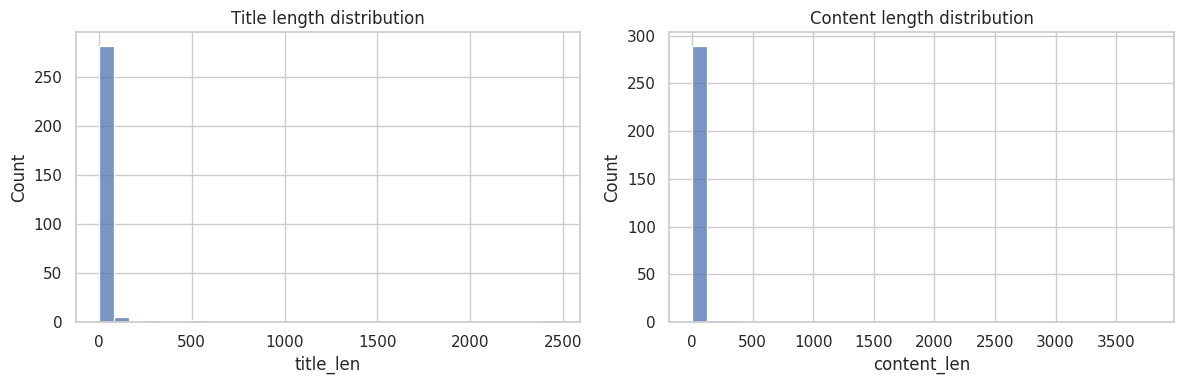

In [53]:
# Simple text length features for EDA
df_model["title_len"] = df_model["title"].str.len()
df_model["content_len"] = df_model["content"].str.len()

fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(df_model["title_len"], bins=30, ax=axes[0])
axes[0].set_title("Title length distribution")

sns.histplot(df_model["content_len"], bins=30, ax=axes[1])
axes[1].set_title("Content length distribution")

plt.tight_layout()
plt.show()

## EDA: target distribution

I first check how many examples we have per class (publication).  
This helps identify class imbalance, which affects model accuracy.

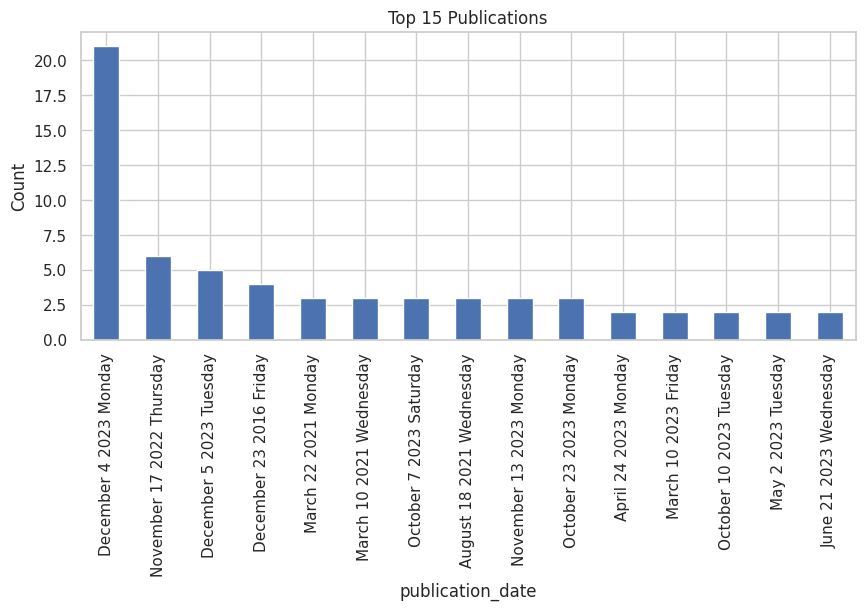

Number of classes: 224
Total rows: 297


In [54]:

top_n = 15
vc = df_model[TARGET].value_counts().head(top_n)

plt.figure(figsize=(10,4))
vc.plot(kind="bar")
plt.title(f"Top {top_n} Publications")
plt.ylabel("Count")
plt.show()

print("Number of classes:", df_model[TARGET].nunique())
print("Total rows:", len(df_model))

## EDA: word_count distribution

I inspect `word_count` to understand article length variation and whether it could help prediction.

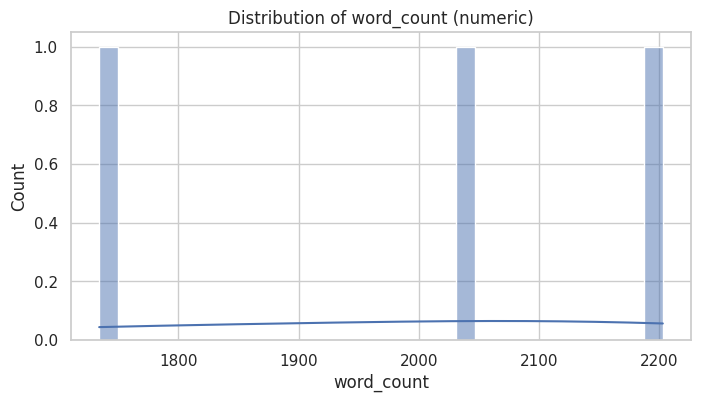

count       3.000000
mean     1990.000000
std       237.438413
min      1734.000000
25%      1883.500000
50%      2033.000000
75%      2118.000000
max      2203.000000
Name: word_count, dtype: float64


In [55]:

plt.figure(figsize=(8,4))
sns.histplot(df_model["word_count"], bins=30, kde=True)
plt.title("Distribution of word_count (numeric)")
plt.show()

print(df_model["word_count"].describe())

## 5) Modeling

This is a text-heavy dataset. To use ML models, text must be converted to numbers.
I use TF-IDF to convert text into numeric features.

Baseline model: Logistic Regression (simple and fast for text classification)

In [56]:
import re
import numpy as np

def extract_first_country(x):
    """
    Country values look like:
    - NaN
    - []
    - ['EGYPT', 'AFRICA', ...]
    This function extracts the first item inside ['...'].
    """
    if pd.isna(x):
        return np.nan
    s = str(x).strip()

    # empty list
    if s == "[]" or s == "":
        return np.nan

    # try to capture first item inside brackets
    m = re.search(r"\['([^']+)'", s)
    if m:
        return m.group(1).strip()

    # otherwise just return the raw text
    return s

df_model = df.copy()

# create cleaned target
df_model["country_clean"] = df_model["country"].apply(extract_first_country)

# drop rows with missing target
df_model = df_model.dropna(subset=["country_clean"]).copy()

print("Rows after cleaning target:", df_model.shape)
print("Top cleaned countries:")
print(df_model["country_clean"].value_counts().head(10))

Rows after cleaning target: (457, 16)
Top cleaned countries:
country_clean
Newstex Blogs                                               14
Targeted News Service                                       10
Copyright 2023 Contify.com All Rights Reserved               8
Copyright 2022 Normans Media Limited All Rights Reserved     6
ENP Newswire                                                 6
States News Service                                          6
Copyright 2021 Newstex LLC All Rights Reserved               5
MENAFN - Press Releases (English)                            5
NAICS522110 COMMERCIAL BANKING                               5
Global Capital Euroweek                                      5
Name: count, dtype: int64
